In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

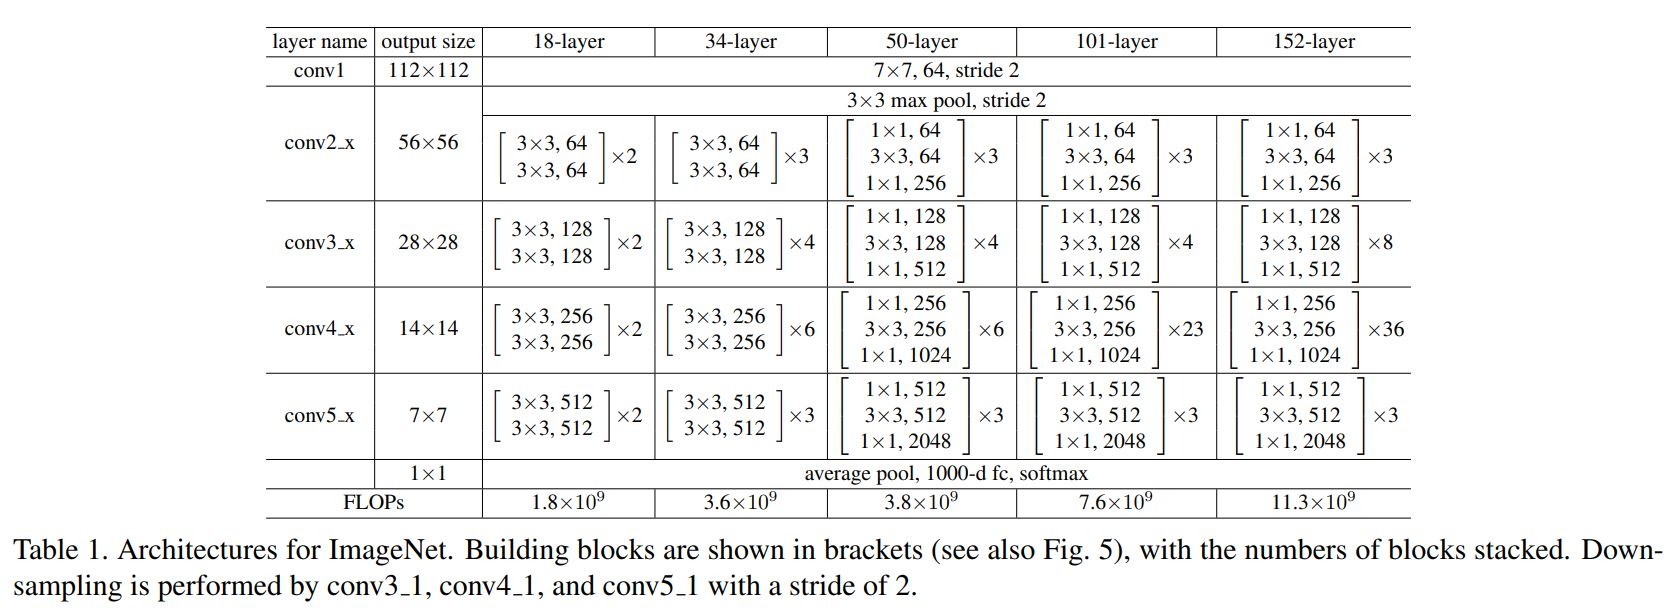

basic block을 연속적으로 여러개를 쌓아 코드를 작성함.
\begin{bmatrix}
3\times3, 64\\ 
3\times3, 64
\end{bmatrix}
위 block은 2개의 conv block으로 구성되어 있음.  
하나의 layer를 거친 결과가 batch normalization, Relu를 거친 후에 다음 layer에 들어가는 것을 확인할 수 있음. 

In [2]:
# function for building ResNet Block
def build_ResNet_block(input_layer ,num_cnn=2,stage_num=2, stride = 1, channel=64, is_50=False):
    x = input_layer
    short = x
        
    if not is_50:
        if stage_num >2:
            short = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        strides=2,
                                        name=f'stage{stage_num}_conv1',
                                        )(short)
            short = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn1')(short)
        for cnn_num in range(num_cnn):
            #print("stage_num", stage_num)
            if stage_num == 2:
                stride = 1
            elif cnn_num == 0:
                stride = 2
            else:
                stride = 1
            # 1st layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=stride,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU1')(x)
            #print("1st layer의 \n")
            #print("x의 shape\n", tf.shape(x))
            #print("short의 shape\n" , tf.shape(short))
            
            # 2nd layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_RELU2')(x)                    
            #x = keras.layers.Activation('relu')(x)
            
            #print("x의 shape\n", tf.shape(x))
            #print("short의 shape\n" , tf.shape(short))
            x = keras.layers.Add()([x, short])
            x = keras.layers.Activation('relu')(x)    
            short = x
    
    else:
        if stage_num == 2:
            strides = 1
        else:
            strides = 2
        short = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1, 1),
                                    padding='same',
                                    strides=strides,
                                    name=f'stage{stage_num}_conv1',
                                    )(short)
        short = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn1')(short)
        
        for cnn_num in range(num_cnn):

            if stage_num == 2:
                stride = 1
            elif cnn_num == 0:
                stride = 2
            else:
                stride = 1
            # 1st layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(1, 1),
                                    padding='same',
                                    strides=stride,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU1')(x)
            
            # 2nd layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)                    
            x = keras.layers.Activation('relu')(x)
            
            # 3rd layer
            x = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1,1),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)                    
            #x = keras.layers.Activation('relu')(x)

            x = keras.layers.Add()([x, short])
            x = keras.layers.Activation('relu')(x)    
            short = x   
    return x

In [3]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(224, 224, 3), is_50=False):
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 10  # 데이터 셋이 cifar10이기 때문에 num_classes를 10으로 변경
    
    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x) 
    x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x) 
    output = x
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_ResNet_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    is_50 = is_50,
                                )
        
    #output = keras.layers.Activation('relu')(output)
    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

## ResNet - 34

In [4]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

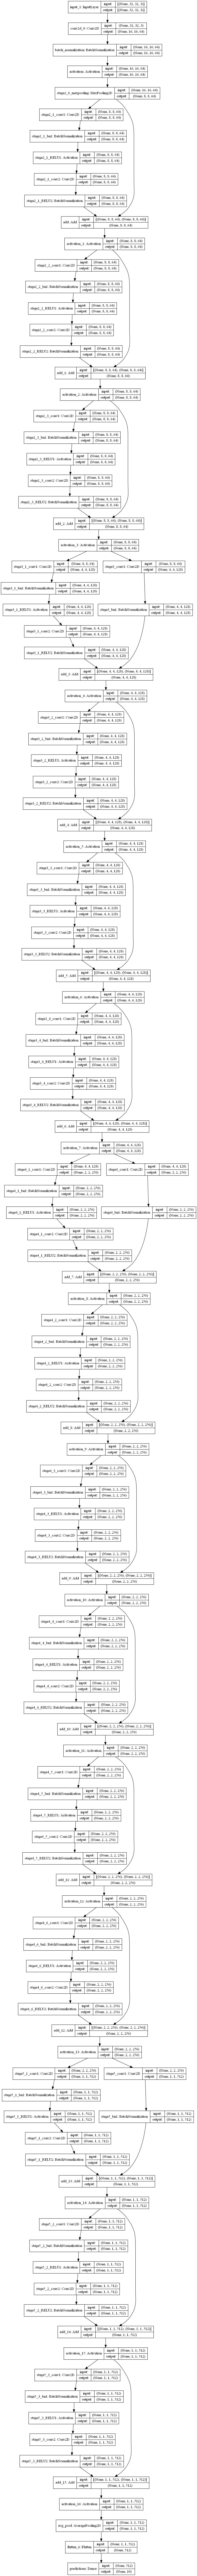

In [5]:
# 모델을 시각화 하기 위한 코드
keras.utils.plot_model(resnet_34, to_file="resnet_34.png", show_shapes=True)

## ResNet - 50

In [6]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

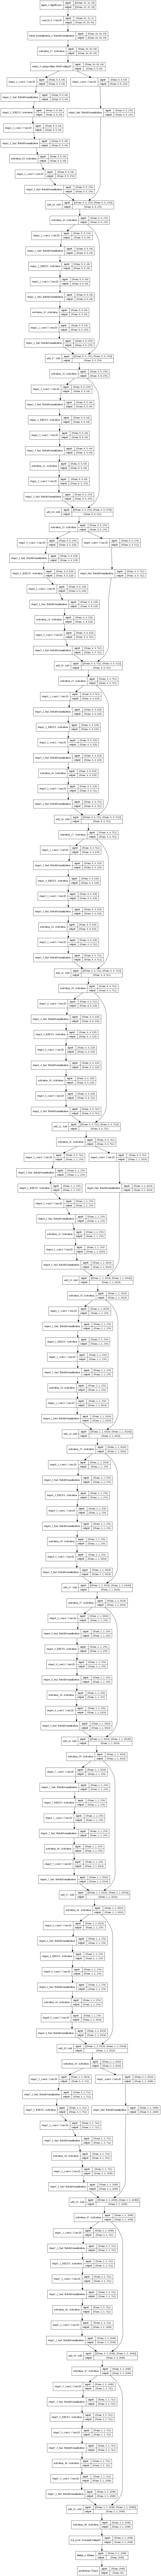

In [7]:
# 모델을 시각화 하기 위한 코드
keras.utils.plot_model(resnet_50, to_file="resnet_50.png", show_shapes=True)

## Plain Network

In [8]:
# function for building Plain Network Block
def build_Plain_block(input_layer ,num_cnn=2,stage_num=2, stride = 1, channel=64, is_50=False):
    x = input_layer
    
    if not is_50:
        for cnn_num in range(num_cnn):
            if stage_num == 2:
                stride = 1
            elif cnn_num == 0:
                stride = 2
            else:
                stride = 1
            # 1st layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=stride,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU1')(x)
            
            # 2nd layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_RELU2')(x)                    
    
    else:    
        for cnn_num in range(num_cnn):

            if stage_num == 2:
                stride = 1
            elif cnn_num == 0:
                stride = 2
            else:
                stride = 1
            # 1st layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(1, 1),
                                    padding='same',
                                    strides=stride,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{cnn_num+1}_RELU1')(x)
            
            # 2nd layer
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)                    
            x = keras.layers.Activation('relu')(x)
            
            # 3rd layer
            x = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1,1),
                                    padding='same',
                                    strides=1,
                                    name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                    )(x)
            x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)                    

    return x

In [9]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_PlainNet(input_shape=(224, 224, 3), is_50=False):
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 1  # 데이터 셋이 cats vs dogs이기 때문에 num_classes를 1으로 변경
    
    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x) 
    x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x) 
    output = x
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_Plain_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    is_50 = is_50,
                                )
        
    #output = keras.layers.Activation('relu')(output)
    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

## Plain - 34

In [10]:
plain_34 = build_PlainNet(input_shape=(224, 224,3), is_50=False)
plain_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_50 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

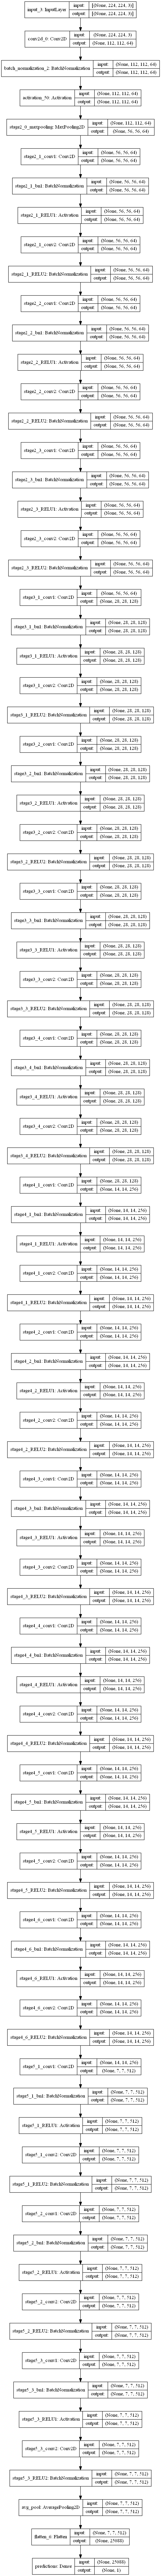

In [11]:
# 모델을 시각화 하기 위한 코드
keras.utils.plot_model(plain_34, to_file="resnet_50.png", show_shapes=True)

## Plain - 50

In [12]:
plain_50 = build_PlainNet(input_shape=(224, 224,3), is_50=True)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_51 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

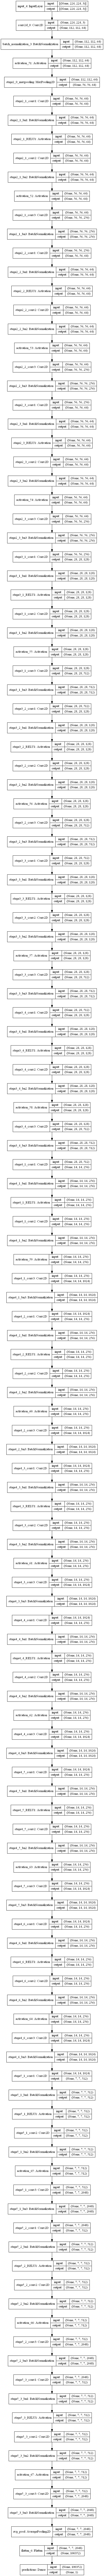

In [13]:
# 모델을 시각화 하기 위한 코드
keras.utils.plot_model(plain_50, to_file="resnet_50.png", show_shapes=True)

## Input Normalization

In [14]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]' ],
    shuffle_files=True,
    with_info=True,
)

In [15]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [16]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [17]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 224.,  tf.cast(label, tf.float32)

In [18]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds= ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## ResNet-34 vs Plain-34

In [19]:
BATCH_SIZE = 256
EPOCH = 3

In [20]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

TypeError: in user code:


    TypeError: tf__normalize_and_resize_img() missing 1 required positional argument: 'label'


In [ ]:
resnet_34